In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_dir = "/content/gdrive/My Drive/MachineLearning/PlantIll/"
base_dir = root_dir + 'DPModel'

In [4]:
!pip install -q torch==1.0.0 torchvision

     |████████████████████████████████| 591.8MB 31kB/s 
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 1.0.0 which is incompatible.


In [0]:
from fastai import *
from fastai.vision import *
from fastai.widgets import *
import torchvision.models
import torch
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _pair
import torch.nn as nn

In [0]:
%reload_ext autoreload 
%autoreload 2
%matplotlib inline

In [0]:
#change directory to where we have our project
import os 
os.getcwd()
os.chdir('/content/gdrive/My Drive/MachineLearning/PlantIll') 

# Getting the data

In [0]:
## our datapath
path = Path('/content/gdrive/My Drive/Datasets/PlantVillage')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [9]:
path.ls()

[PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/val'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/train'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/models'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/tmp.pth'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/test.jpg')]

In [0]:
##### Data **augmentation** 
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src  = ImageList.from_folder(path)

In [0]:
sd = (src.split_by_folder(train='train', valid='val'))

In [0]:
labellists =(sd.label_from_folder())

In [0]:
##batch size 
bs= 128
## we will use it in progrissive resizing at the beggining it was 256//2
img_size = 256//2

In [0]:
labellists = (labellists.transform(tfms , size=img_size))

In [0]:
## our data bunch, it contains ou data loaders 
data =  labellists.databunch(bs=bs).normalize(imagenet_stats)

In [17]:
print(data.classes)
len(data.classes),data.c

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

(39, 39)

# Our Model 

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
#https://github.com/iKintosh/GaborNet

class GaborConv2d(_ConvNd):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=False):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)

        super(GaborConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, False, _pair(0), groups, bias)
        self.freq = nn.Parameter((3.14/2)*1.41**(-torch.randint(0, 5, (out_channels, in_channels))).type(torch.Tensor))
        self.theta = nn.Parameter((3.14/8)*torch.randint(0, 8, (out_channels, in_channels)).type(torch.Tensor))
        self.psi = nn.Parameter(3.14*torch.rand(out_channels, in_channels))
        self.sigma = nn.Parameter(3.14/self.freq)
        self.x0 = torch.ceil(torch.Tensor([self.kernel_size[0]/2]))[0]
        self.y0 = torch.ceil(torch.Tensor([self.kernel_size[1]/2]))[0]

    def forward(self, input):
        y, x = torch.meshgrid([torch.linspace(-self.x0+1, self.x0, self.kernel_size[0]), torch.linspace(-self.y0+1, self.y0, self.kernel_size[1])])
        x = x.to(device)
        y = y.to(device)
        weight = torch.empty(self.weight.shape, requires_grad=False).to(device)
        for i in range(self.out_channels):
            for j in range(self.in_channels):
                sigma = self.sigma[i, j].expand_as(y)
                freq = self.freq[i, j].expand_as(y)
                theta = self.theta[i, j].expand_as(y)
                psi = self.psi[i, j].expand_as(y)

                rotx = x * torch.cos(theta) + y * torch.sin(theta)
                roty = -x * torch.sin(theta) + y * torch.cos(theta)

                g = torch.zeros(y.shape)

                g = torch.exp(-0.5 * ((rotx ** 2 + roty ** 2) / (sigma + 1e-3) ** 2))
                g = g * torch.cos(freq * rotx + psi)
                g = g / (2*3.14*sigma**2)
                weight[i, j] = g
                self.weight.data[i, j] = g
        return F.conv2d(input, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)



In [20]:
gabor_model = torchvision.models.resnet.resnet18(pretrained=True)
nf = data.c # number of output classes in your data

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 87258502.52it/s]


In [0]:
for param in gabor_model.parameters():
  param.requires_grad = False

In [0]:
num_ftrs2 = gabor_model.fc.in_features
gabor_model.fc = nn.Linear(num_ftrs2, nf)

In [0]:
gabor_model.conv1 = GaborConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [0]:
gabor_model = gabor_model.cuda()

In [0]:
## fbeta is F1 score fbeta,
learn = Learner(data, gabor_model, metrics=[accuracy])

In [0]:
learn.summary()

ResNet
Layer (type)         Output Shape         Param #    Trainable 
GaborConv2d          [64, 64, 64]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        False     
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        False     
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
_______________________________________________________

In [0]:
learn.lr_find()
learn.recorder.plot()

# Train the model

In [27]:
learn.fit_one_cycle(7, max_lr=slice(1e-3, 6e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.751335,2.320350,0.418162,1:39:32
1,1.520502,1.296484,0.645885,04:27
2,1.097988,0.973597,0.718286,04:29
3,0.935722,0.846897,0.749845,04:29
4,0.848688,0.785115,0.769647,04:30
5,0.830685,0.758363,0.776454,04:28
6,0.795249,0.756925,0.775062,04:30


In [0]:
learn.save('gabor-resnet18-weight-1')

Plotting Losses


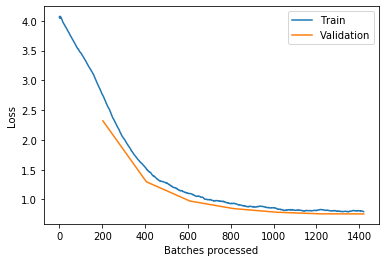

In [29]:
print("Plotting Losses")
learn.recorder.plot_losses()


Plotting metrics


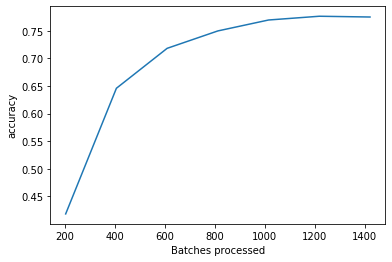

In [30]:
print("Plotting metrics")
learn.recorder.plot_metrics()


Plotting LR


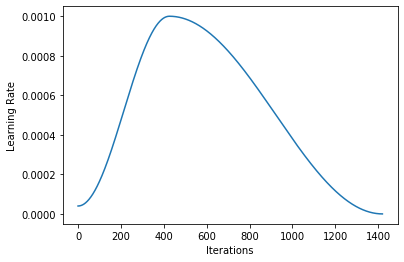

In [31]:
print("Plotting LR")
learn.recorder.plot_lr()

In [0]:
learn.load('gabor-resnet18-weight-1');

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(7, max_lr=slice(1e-3, 6e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.017630,1.516748,0.595916,05:05
1,0.702303,2.020158,0.528620,05:07
2,0.445007,0.853124,0.741491,05:08
3,0.298269,0.374297,0.876083,05:07
4,0.180196,0.213158,0.932085,05:06
5,0.107908,0.102080,0.966120,05:05
6,0.074072,0.082006,0.972618,05:07


In [0]:
learn.save('gabor-resnet18-weight-2')

In [0]:
# before we start the last phase of training we change img_size = 256//2 to img_size = 256
# this change is called progrissive resizing in fastai this method helps
# the model to learn and get a better accuracy 

In [0]:
##batch size 
bs= 128
## we will use it in progrissive resizing at the beggining it was 256//2
img_size = 256

In [0]:
labellists = (labellists.transform(tfms , size=img_size))
data =  labellists.databunch(bs=bs).normalize(imagenet_stats)

In [0]:
gabor_model = torchvision.models.resnet.resnet18()
nf = data.c # number of output classes in your data

In [0]:
for param in gabor_model.parameters():
  param.requires_grad = False

In [0]:
num_ftrs2 = gabor_model.fc.in_features
gabor_model.fc = nn.Linear(num_ftrs2, nf)

In [0]:
gabor_model.conv1 = GaborConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [0]:
gabor_model = gabor_model.cuda()

In [0]:
learn = Learner(data, gabor_model, metrics=[accuracy])

In [0]:
learn.load('gabor-resnet18-weight-2');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(7, max_lr=slice(1e-3, 6e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.150639,0.317268,0.896504,08:57
1,0.246937,0.856272,0.754022,08:55
2,0.187228,0.415495,0.863088,08:55
3,0.126201,0.158540,0.947710,08:58
4,0.075454,0.131177,0.956528,08:59
5,0.036949,0.045202,0.986541,08:56
6,0.024879,0.036853,0.989480,08:57


In [0]:
learn.save('gabor-resnet18-weight-3')

In [0]:
learn.load('gabor-resnet18-weight-3');

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(7, max_lr=slice(1e-3, 6e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.053569,0.150600,0.948020,09:02
1,0.126661,0.453783,0.866337,08:53
2,0.103450,0.322674,0.900217,08:53
3,0.075885,0.175894,0.946009,08:56
4,0.045358,0.066598,0.977723,08:58
5,0.024053,0.032839,0.991955,08:52
6,0.014820,0.027559,0.992729,08:50


In [0]:
learn.save('gabor-resnet18-weight-4')

In [0]:
learn.load('gabor-resnet18-weight-4');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(7, max_lr=slice(1e-3, 6e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.032648,0.107636,0.964264,09:00
1,0.092946,0.245951,0.926516,09:02
2,0.075197,0.253466,0.925433,09:00
3,0.052218,0.080053,0.975557,08:59
4,0.029428,0.043602,0.987005,08:57
5,0.015462,0.030058,0.991337,08:56
6,0.010148,0.024866,0.993193,08:59


In [0]:
learn.save('gabor-resnet18-weight-5')

Plotting Losses


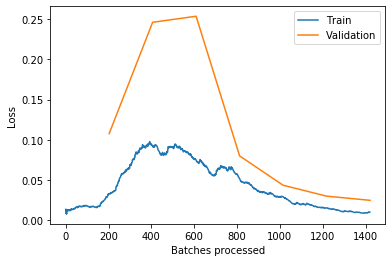

In [0]:
print("Plotting Losses")
learn.recorder.plot_losses()

Plotting metrics


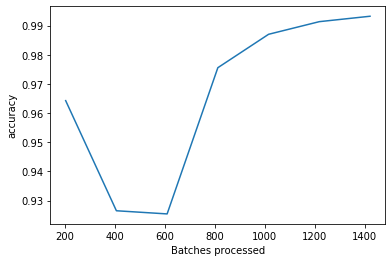

In [0]:
print("Plotting metrics")
learn.recorder.plot_metrics()

Plotting LR


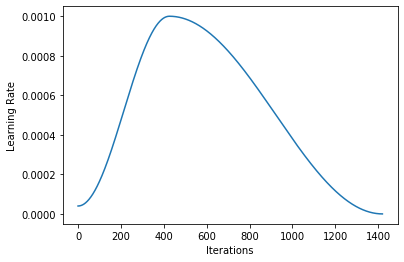

In [0]:
print("Plotting LR")
learn.recorder.plot_lr()

In [0]:
learn.load('gabor-resnet18-weight-5');

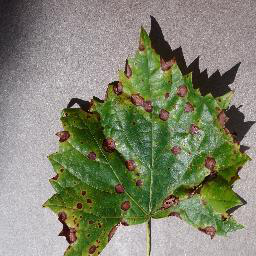

In [0]:
#/content/gdrive/My Drive/Datasets/PlantVillage/val/Grape___Black_rot/test.jpg
#/content/gdrive/My Drive/Datasets/PlantVillage/test.jpg
img = open_image(Path('/content/gdrive/My Drive/Datasets/PlantVillage/val/Grape___Black_rot/test.jpg'))
img

In [0]:
print("Gabor Resnet time --------------")
%time pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Gabor Resnet time --------------
CPU times: user 135 ms, sys: 4.5 ms, total: 139 ms
Wall time: 140 ms


Category Grape___Black_rot